# Pulse Level Learning

In this notebook, we will train a reinforcement learning agent to learn pulse level control of a quantum system. The configuration is drawn from two dedicated yaml files respectively describing the quantum environment and the agent. The quantum environment is a `QuantumEnvironment` object, which is a subclass of `gym.Env ` and is designed to be compatible with standard RL libraries. The agent on the other hand, is specifically hard coded for our need because of the need to be able to send to the same resource (the Estimator primitive) a batch of quantum circuits (in contrast with usual RL frameworks where actions can be evaluated in parallel).

For this notebook, we take all necessary inputs from the `pulse_config.py` file. This python file contains all elements necessary to create a pulse-level quantum environment. The file contains the following elements:
- a parametrized gate function, coded through Qiskit; leveraging behind the scenes a custom parametrized pulse schedule, to be inserted in the quantum circuit. The function needs to modify an input parametrized quantum circuit, by adding the parametrized gate.
- a Qiskit backend object, which is the quantum hardware or simulator on which the quantum circuits will be run. The backend is retrieved through another template function called get_backend.
- A circuit context, which is a `QuantumCircuit` object that contains the quantum circuit in which the target gate operation should be optimized. The context is used to create the `ContextAwareQuantumEnvironment` object, which is a subclass of `BaseQuantumEnvironment` that takes into account the context of the quantum circuit in which the gate is to be optimized.

We provide a dedicated template for IBM devices working through ECR, X, and SX basis gates. The user can adapt this to the platform and basis gates of his choice.

In [1]:
%matplotlib inline
from pulse_config import (
    q_env_config as pulse_q_env_config,
    circuit_context,
)
from rl_qoc import ContextAwareQuantumEnvironment, QuantumEnvironment, CustomPPO
from gymnasium.wrappers import RescaleAction, ClipAction
from qiskit.circuit import QuantumCircuit
from rl_qoc.helper_functions import simulate_pulse_schedule, load_from_yaml_file
from qiskit.quantum_info import Operator, Statevector
from qiskit import pulse
import numpy as np

Custom backend used
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'z', 'sdg', 'h', 't', 'x', 'rz', 'reset', 'tdg', 'sx', 's', 'id', 'measure', 'delay'}
  q1: {'z', 'sdg', 'h', 't', 'x', 'rz', 'reset', 'tdg', 'sx', 's', 'id', 'measure', 'delay'}
Multi qubit instructions:
  (0, 1): {'cr45m', 'ecr', 'cr45p'}
  (1, 0): {'cr45m', 'ecr', 'cr45p'}
)>
Circuit context: 
         ┌───┐ ░ ┌─────┐          ┌──────┐┌───┐┌───┐┌─────┐┌──────┐┌───┐
q_0 -> 0 ┤ H ├─░─┤ Sdg ├──────────┤0     ├┤ X ├┤ H ├┤ Sdg ├┤0     ├┤ X ├
         └───┘ ░ └┬───┬┘┌───┐┌───┐│  Ecr │├───┤├───┤└┬───┬┘│  Ecr │└───┘
q_1 -> 1 ──────░──┤ S ├─┤ H ├┤ S ├┤

In [2]:
use_context = False

if use_context:
    q_env = ContextAwareQuantumEnvironment(
        pulse_q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironment(pulse_q_env_config)
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

[Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), Instruction(name='z', num_qubits=1, num_clbits=0, params=[]), Instruction(name='s', num_qubits=1, num_clbits=0, params=[]), Instruction(name='sdg', num_qubits=1, num_clbits=0, params=[]), Instruction(name='t', num_qubits=1, num_clbits=0, params=[]), Instruction(name='tdg', num_qubits=1, num_clbits=0, params=[]), Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]), Instruction(name='id', num_qubits=1, num_clbits=0, params=[]), Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]), Delay(duration=t[unit=dt]), Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[]), Instruction(name='cr45p', num_qubits=2, num_clbits=0, params=[]), Instruction(name='cr45m', num_qubits=2, num_clbits=0, params=[]), In

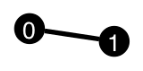

In [3]:
from qiskit.visualization import plot_gate_map, plot_circuit_layout
from qiskit.transpiler import Target

print(q_env.backend.target.operations)
plot_circuit_layout(circuit_context, backend=q_env.backend)

In [4]:
q_env.estimator

In [5]:
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = Path.cwd() / file_name

agent_config = load_from_yaml_file(file_location)

In [6]:
ppo_agent = CustomPPO(agent_config, rescaled_env)

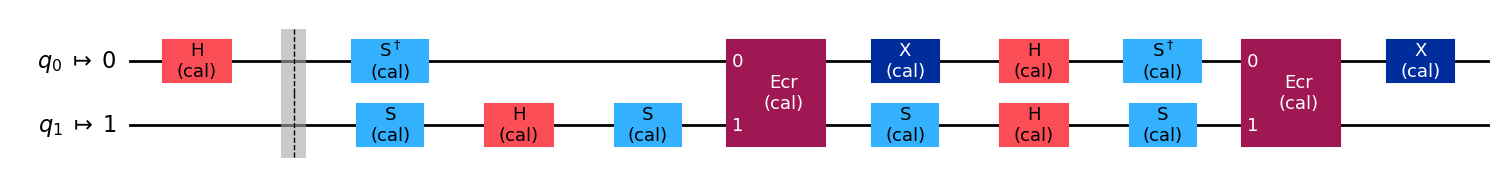

In [7]:
circuit_context.draw("mpl")

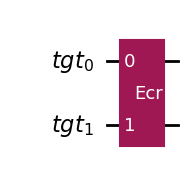

In [8]:
q_env.baseline_circuits[0].draw("mpl")

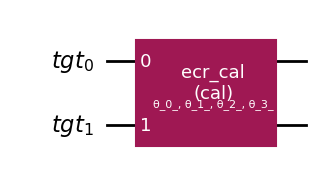

In [9]:
circuit = q_env.circuits[0]
circuit.draw("mpl")

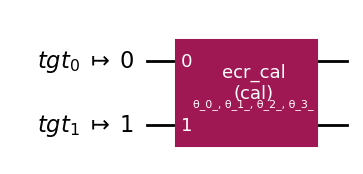

In [10]:
from qiskit import transpile, schedule

circ = transpile(circuit, q_env.backend)
circ.draw("mpl")

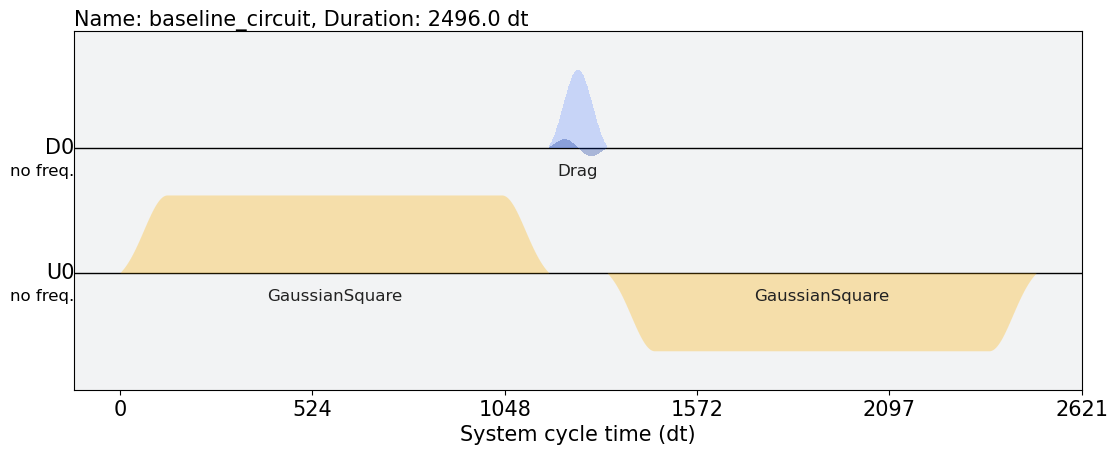

In [11]:
schedule(q_env.baseline_circuits[0], q_env.backend).draw()

In [12]:
print(q_env.backend.target)

Target
Number of qubits: 2
Instructions:
	measure
		(0,):
			Duration: 2.2222000000000001e-07 sec.
			Error Rate: 0.0
			With pulse schedule calibration
		(1,):
			Duration: 2.2222000000000001e-07 sec.
			Error Rate: 0.0
			With pulse schedule calibration
	z
		(0,):
			Duration: 0.0 sec.
			Error Rate: 0.0
			With pulse schedule calibration
		(1,):
			Duration: 0.0 sec.
			Error Rate: 0.0
			With pulse schedule calibration
	s
		(0,):
			Duration: 0.0 sec.
			Error Rate: 0.0
			With pulse schedule calibration
		(1,):
			Duration: 0.0 sec.
			Error Rate: 0.0
			With pulse schedule calibration
	sdg
		(0,):
			Duration: 0.0 sec.
			Error Rate: 0.0
			With pulse schedule calibration
		(1,):
			Duration: 0.0 sec.
			Error Rate: 0.0
			With pulse schedule calibration
	t
		(0,):
			Duration: 0.0 sec.
			Error Rate: 0.0
			With pulse schedule calibration
		(1,):
			Duration: 0.0 sec.
			Error Rate: 0.0
			With pulse schedule calibration
	tdg
		(0,):
			Duration: 0.0 sec.
			Error Rate: 0.0
			W

In [13]:
from rl_qoc.ppo_config import TotalUpdates, TrainFunctionSettings, TrainingConfig

total_updates = TotalUpdates(500)
# hardware_runtime = HardwareRuntime(300)
training_config = TrainingConfig(
    training_constraint=total_updates,
    target_fidelities=[0.999, 0.9999],
    lookback_window=10,
    anneal_learning_rate=False,
    std_actions_eps=1e-2,
)

train_function_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=True,
    num_prints=1,
    hpo_mode=False,
    clear_history=True,
)

In [14]:
q_env.backend.instruction_durations.duration_by_name_qubits

{('measure', (0,)): (2.2222000000000001e-07, 's'),
 ('measure', (1,)): (2.2222000000000001e-07, 's'),
 ('z', (0,)): (0.0, 's'),
 ('z', (1,)): (0.0, 's'),
 ('s', (0,)): (0.0, 's'),
 ('s', (1,)): (0.0, 's'),
 ('sdg', (0,)): (0.0, 's'),
 ('sdg', (1,)): (0.0, 's'),
 ('t', (0,)): (0.0, 's'),
 ('t', (1,)): (0.0, 's'),
 ('tdg', (0,)): (0.0, 's'),
 ('tdg', (1,)): (0.0, 's'),
 ('rz', (0,)): (0, 's'),
 ('rz', (1,)): (0, 's'),
 ('id', (0,)): (4.4444e-09, 's'),
 ('id', (1,)): (4.4444e-09, 's'),
 ('h', (0,)): (3.55552e-08, 's'),
 ('h', (1,)): (3.55552e-08, 's'),
 ('x', (0,)): (3.55552e-08, 's'),
 ('x', (1,)): (3.55552e-08, 's'),
 ('sx', (0,)): (3.55552e-08, 's'),
 ('sx', (1,)): (3.55552e-08, 's'),
 ('reset', (0,)): (2.2222000000000001e-07, 's'),
 ('reset', (1,)): (2.2222000000000001e-07, 's'),
 ('ecr', (0, 1)): (5.546611200000001e-07, 's'),
 ('ecr', (1, 0)): (5.546611200000001e-07, 's'),
 ('cr45p', (0, 1)): (2.5955296e-07, 's'),
 ('cr45p', (1, 0)): (2.5955296e-07, 's'),
 ('cr45m', (0, 1)): (2.59552

In [15]:
ppo_agent.train(
    training_config=training_config, train_function_settings=train_function_settings
)

100%|██████████| 500/500 [1:59:16<00:00, 14.31s/it]

2024-08-07 19:28:45 INFO Target fidelity 0.999 achieved: Update 241, Hardware Runtime: 2.33 sec, Simulation Train Time: 29.7857 mins, Shots Used 2,477,568
2024-08-07 19:28:45 INFO Target fidelity 0.9999 achieved: Update 242, Hardware Runtime: 2.34 sec, Simulation Train Time: 29.8857 mins, Shots Used 2,483,712


{'env_ident_str': 'gate_calibration_ecr-gate_physical_qubits_0-1',
 'reward_method': 'state',
 'training_constraint': TotalUpdates(total_updates=500),
 'avg_reward': [0.01529947916666667,
  0.4546595982142857,
  0.47781808035714274,
  0.7190896739130435,
  0.462890625,
  0.47325721153846156,
  0.24937500000000007,
  0.27944711538461536,
  0.46739130434782594,
  0.4762369791666666,
  0.4480298913043477,
  0.22607421875000006,
  0.0741436298076923,
  0.33648437500000006,
  0.054931640625,
  0.2543131510416667,
  0.49853515625,
  0.2524181547619048,
  0.1988932291666667,
  0.022078804347826088,
  0.09188179347826086,
  0.02483258928571428,
  0.4670973557692306,
  0.24537037037037038,
  0.08500339673913043,
  0.2936789772727273,
  0.4587499999999999,
  0.4740767045454545,
  0.02222521551724138,
  0.24744591346153844,
  0.3330775669642858,
  0.45533288043478254,
  0.022812499999999996,
  0.25187174479166663,
  0.33567116477272735,
  0.44242527173913043,
  0.252632472826087,
  0.0224609375,


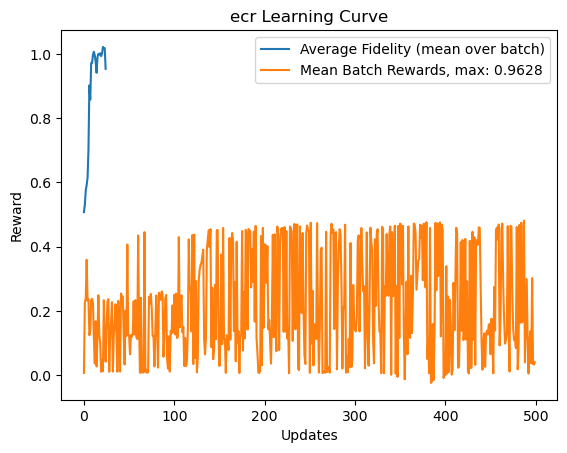

In [16]:
from rl_qoc import GateTarget
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4
n_epochs = len(mean_rewards)
if q_env.benchmark_cycle != 0:
    fidelity_range = np.arange(0, n_epochs, q_env.benchmark_cycle)
    plt.plot(
        # fidelity_range,
        np.array(q_env.fidelity_history),
        label="Average Fidelity (mean over batch)",
    )
plt.plot(mean_rewards / 2, label=f"Mean Batch Rewards, max: {max_mean}")

plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name if isinstance(q_env.target, GateTarget) else ''} Learning Curve"
)
plt.legend()
plt.show()

In [17]:
print("Optimal action", q_env.optimal_action)
print("Best fidelity:", np.max(q_env.fidelity_history))

Optimal action [0.59852636 0.06035089 0.99969435 0.26956105]
Best fidelity: 1.0218365172445982


In [18]:
cal = q_env.backend.target.get_calibration("x", (0,))
from qiskit.circuit.library import CXGate, HGate, RZGate, ECRGate
from qiskit.quantum_info import average_gate_fidelity, Operator, Statevector

data = simulate_pulse_schedule(q_env.backend, cal)

print(data)

{'unitary': Operator([[ 1.36727792e-04+1.56113331e-01j,
            1.64569200e-02-9.86972524e-01j,
           -6.64123601e-04+3.53223277e-02j,
            4.29228848e-06-7.49741513e-05j],
          [-1.60923749e-02-9.86976582e-01j,
            1.95358178e-04-1.55707861e-01j,
            1.28962375e-06+1.12436838e-02j,
            4.82094455e-04-3.53798168e-02j],
          [ 4.82094455e-04+3.53798168e-02j,
           -1.28962376e-06+1.12436838e-02j,
            1.95358178e-04+1.55707861e-01j,
            1.60923749e-02-9.86976582e-01j],
          [-4.29228848e-06-7.49741513e-05j,
           -6.64123601e-04-3.53223277e-02j,
           -1.64569200e-02-9.86972524e-01j,
            1.36727792e-04-1.56113331e-01j]],
         input_dims=(2, 2), output_dims=(2, 2)), 'statevector': Statevector([ 1.36727792e-04+1.56113331e-01j,
             -1.60923749e-02-9.86976582e-01j,
              4.82094455e-04+3.53798168e-02j,
             -4.29228848e-06-7.49741513e-05j],
            dims=(2, 2)), 'pro

In [19]:
# Update the gate calibration in the backend target and retrieve the calibration
optimal_calibration = q_env.update_gate_calibration()
q_env.backend.target.get_calibration("x", (0,)).draw()

PulseError: 'Unassigned parameter exists. All parameters must be assigned.'

In [ ]:
from qiskit.circuit.library import CXGate, HGate, RZGate, ECRGate
from qiskit.quantum_info import average_gate_fidelity, Operator, Statevector

data = simulate_pulse_schedule(
    q_env.backend,
    optimal_calibration,
    target_unitary=Operator(q_env.target["gate"]),
)

print(data)

In [ ]:
q_env.estimator

In [ ]:
# Testing gate in a quantum circuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw("mpl")

basic_simulator = BasicSimulator()
basic_result = basic_simulator.run(qc).result()

pulse_circ = transpile(qc, q_env.backend)
q_env.backend.options.shots = 1000
pulse_results = q_env.backend.run(pulse_circ).result()

print("BasicProvider: ", basic_result.get_counts())
print("Custom Backend:", pulse_results.get_counts())

In [ ]:
pulse_circ.draw("mpl")

In [ ]:
# Testing the pulse schedule
from qiskit import schedule

pulse_schedule = schedule(
    pulse_circ.remove_final_measurements(inplace=False), q_env.backend
)
pulse_schedule.draw()

In [ ]:
# Testing the pulse schedule
pulse_sim_results = simulate_pulse_schedule(
    q_env.backend,
    pulse_schedule,
    target_unitary=Operator(pulse_circ.remove_final_measurements(inplace=False)),
    target_state=(Statevector.from_label("00") + Statevector.from_label("11"))
                 / np.sqrt(2),
)
print(pulse_sim_results)

In [ ]:
new_circ = transpile(
    pulse_circ.remove_final_measurements(inplace=False),
    q_env.backend,
    scheduling_method="asap",
)
new_circ.draw("mpl")

In [ ]:
new_circ.op_start_times

In [ ]:
instruction_list = []
for instruction in new_circ.data:
    instruction_list.append(instruction.operation.name)
instruction_list

In [ ]:
from rl_qoc.helper_functions import new_params_ecr
from pulse_config import custom_schedule

new_params_ecr(
    q_env.parameters[0],
    tuple(q_env.physical_target_qubits),
    q_env.backend,
    ["amp", "tgt_amp", "angle", "tgt_angle"],
)

custom_schedule(q_env.backend, q_env.physical_target_qubits, q_env.parameters[0])